In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline

### Let's load the Mnist dataset and start a TensorFlow session

In [2]:
# mnist is a lightweight class which stores the training, validation, and testing sets 
#as NumPy arrays. It also provides a function for iterating through data minibatches, 
#which we will use below.
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [3]:
xtest = mnist.test.images[1,:]
xtest = xtest.reshape(28,28)

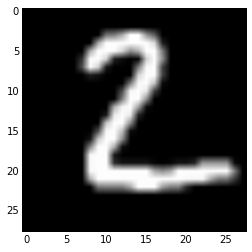

In [4]:
plt.imshow(xtest,'gray')

Tensorflow relies on a highly efficient C++ backend to do its computation. The connection to this backend is called a session. The common usage for TensorFlow programs is to first create a graph and then launch it in a session

Here we instead use the convenient InteractiveSession class, which makes TensorFlow more flexible about how you structure your code. It allows you to interleave operations which build a computation graph with ones that run the graph. 

### Define the tensor flow session

In [5]:
sess = tf.InteractiveSession()

TensorFlow lets us describe a graph of interacting operations that run entirely outside Python. This approach is similar to that used in Theano or Torch. 
The role of the Python code is therefore to build this external computation graph, and to dictate which parts of the computation graph should be run.

### Let's start building the computation graph

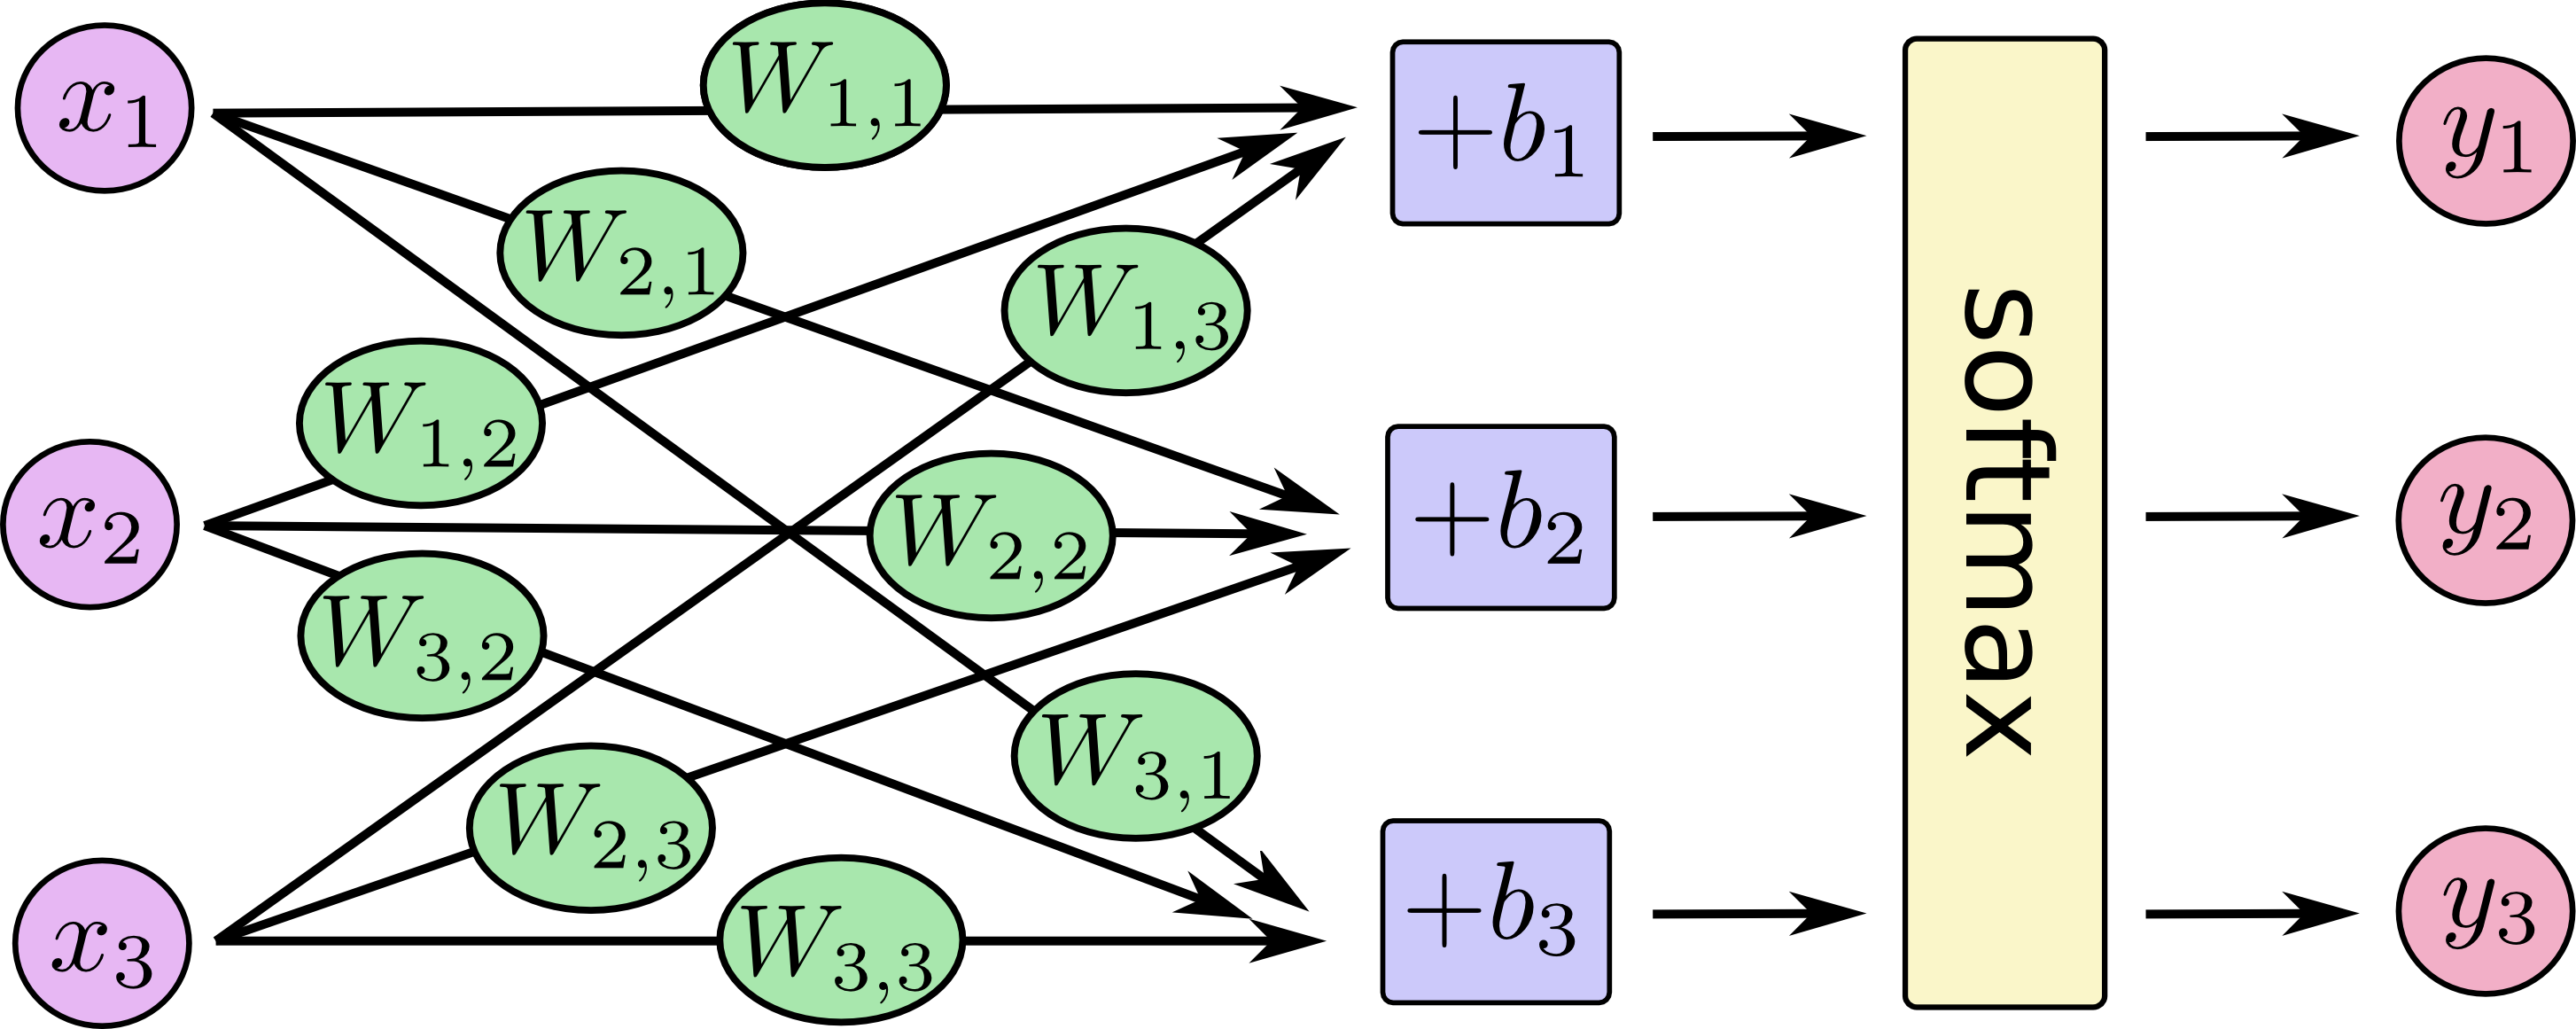

In [6]:
from IPython.display import Image
Image('Figs/softmax-regression-scalargraph.png')

We define the PLACEHOLDERS, values that we'll input when we ask TensorFlow to run a computation.



In [7]:
x = tf.placeholder("float",[None,784], name="x-input") 
y_ = tf.placeholder("float",[None,10],name="y-target")
#None means the dimension can be of any length

x and y_ are tensors and will contain the value of the input images (28x28) and the output class respectively

Now we define VARIABLES, values that live in TensorFlow computation graph

In [8]:
W = tf.Variable(tf.zeros([784,10]),name='Weights')
b = tf.Variable(tf.zeros([10]),name='biases')

Add summary ops to collect and visualize data

In [9]:
w_hist = tf.histogram_summary("Weights",W)
b_hist = tf.histogram_summary("biases",b)

### Initialize All the variables

In [10]:
sess.run(tf.initialize_all_variables())

### Implement the model
We multiple the weight matrix with the input, add the bias b, and finally apply the Softmax

We use name_scope to organize nodes in the graph visualizer

In [11]:
with tf.name_scope("Wx_b") as scope:
    y = tf.nn.softmax(tf.matmul(x,W) + b)
    y_hist = tf.histogram_summary("y",y)

Specify the cost function to be minimized as the Cross Entropy:  −∑y′log(y)

y_ is the target, y is the model prediction

The cross entropy is computed over the mini batch

In [12]:
with tf.name_scope("xent") as scope:
    cross_entropy = -tf.reduce_sum(y_*tf.log(y))
    ce_summary = tf.scalar_summary("cross-entropy",cross_entropy)

### Train the model

Because TensorFlow knows the entire computation graph, it can use automatic differentiation to find the gradients of the cost with respect to each of the variables.

In [13]:
with tf.name_scope("train") as scope:
    train_step = tf.train.GradientDescentOptimizer(0.01).minimize(cross_entropy)

With this line we are adding the following operations to the graph:
* Compute Gradient
* Compute paramater update
* Apply update step to parameters

The returned operation train_step applies one step of the above operations

### Define a node that computes and stores the accuracy on the test set

In [14]:
with tf.name_scope("test") as scope:
    correct_prediction = tf.equal(tf.argmax(y,1),tf.argmax(y_,1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction,"float"))
    accuracy_summary = tf.scalar_summary("accuracy",accuracy)

Merge all the summaries and write them out to /tmp/mnist_logs

In [15]:
merged = tf.merge_all_summaries() #stores all the summaries
writer = tf.train.SummaryWriter("./tmp/mnist_logs", sess.graph_def)
tf.initialize_all_variables().run()

In [16]:
for i in range(100):
    if i%10 == 0: # Record summary data, and the accuracy
        feed = {x:mnist.test.images, y_:mnist.test.labels}
        result = sess.run([merged,accuracy],feed_dict=feed)
        summary_str = result[0]
        acc = result[1]
        writer.add_summary(summary_str,i)
        print('accuracy at step %s: %s'%(i,acc))
        
    else:
        batch_xs,batch_ys = mnist.train.next_batch(100)
        feed = {x:batch_xs, y_:batch_ys}
        sess.run(train_step, feed_dict=feed)
        
print(accuracy.eval(feed_dict={x:mnist.test.images, y_:mnist.test.labels}))

accuracy at step 0: 0.098
accuracy at step 10: 0.7404
accuracy at step 20: 0.8041
accuracy at step 30: 0.814
accuracy at step 40: 0.8421
accuracy at step 50: 0.8381
accuracy at step 60: 0.8518
accuracy at step 70: 0.8403
accuracy at step 80: 0.8066
accuracy at step 90: 0.8624
0.871


### Build a multilayer conv net

Let's start by defining an init fcn for weights and biases. We want weights with a small amount of noise to prevent 0 gradients and a slightly positive bias

In [17]:
def weight_variable(shape):
    initial = tf.truncated_normal(shape,stddev=0.1)
    return tf.Variable(initial)

def bias_variable(shape):
    initial = tf.constant(0.1,shape=shape)
    return tf.Variable(initial)

Define convolution and pooling operations
* Convolution - stride of 1 and 0 padded
* Max pooling over 2x2 blocks

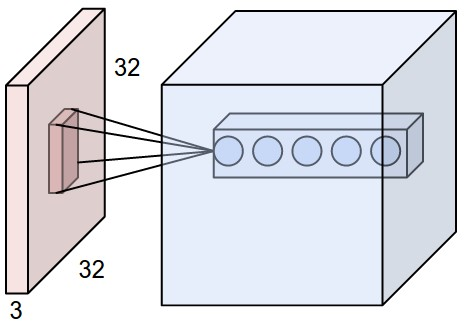

In [18]:
Image('Figs/Convnet1.jpeg')

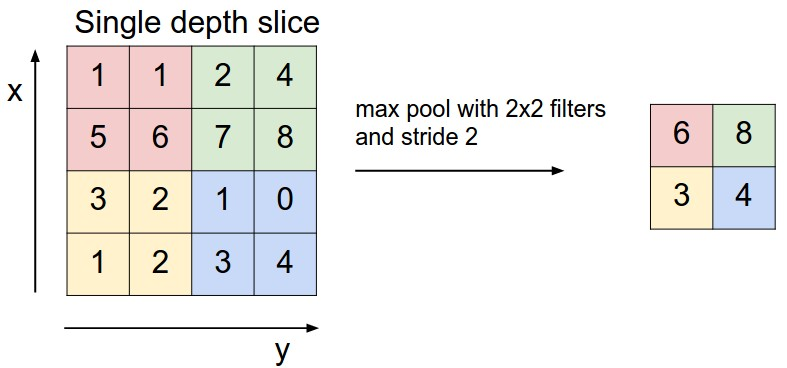

In [19]:
Image('Figs/maxpool2.jpeg')

For simplicity of notation, we define the 2 operations with the stride 1 and 2, respectively. 
For the 'SAME' padding in the convolution, the output height and width are computed as:

out_height = ceil(float(in_height) / float(strides[1]))

out_width  = ceil(float(in_width) / float(stides[2]))

In [20]:
def conv2d(x, W):
    return tf.nn.conv2d(x,W, strides=[1,1,1,1], padding='SAME')
    
def max_pool_2x2(x):
    return tf.nn.max_pool(x, ksize=[1,2,2,1], strides=[1,2,2,1], padding='SAME')

Define the convolutional layer of size (depth) 32, with input patches of size 5x5. The input depth (# of channels) is 1 cause images are grayscale.

Therefore the tensor describing this layer will have a shape of [5, 5, 1, 32]. The first two dimensions are the patch size, the next is the number of input channels, and the last is the number of output channels (i.e. different neurons or feature detectors). We will also have a bias vector with a component for each output channel.

In [21]:
W_conv1 = weight_variable([5,5,1,32])
b_conv1 = bias_variable([32])

To apply the layer, we first reshape x to a 4d tensor, with the second and third dimensions corresponding to image width and height, and the final dimension corresponding to the number of color channels.

In [22]:
x_image = tf.reshape(x, [-1,28,28,1]) #Notice that x is a PLACEHOLDER of size 784,
#-1 indicates to preserve the dimension provided (in this case the batch size)

We then convolve x_image with the weight tensor, add the bias, apply the ReLU function, and finally max pool.

We use TensorFlow RELU fcn and the CONV2d fcn we defined above

In [23]:
h_conv1 = tf.nn.relu(conv2d(x_image,W_conv1) + b_conv1)
h_pool1 = max_pool_2x2(h_conv1)

### Let's add another layer
this time we use 64 neurons. Note that the 3rd dimension (depth of input) is now 32

In [24]:
W_conv2 = weight_variable([5,5,32,64])
b_conv2 = bias_variable([64])

In [25]:
h_conv2 = tf.nn.relu(conv2d(h_pool1,W_conv2) + b_conv2)
h_pool2 = max_pool_2x2(h_conv2)

### Now we add a fully connected layer with 1024 neurons
Note that the output of the second maxpool is a 7x7x64 tensor

In [26]:
Wfc_1 = weight_variable([7*7*64, 1024]) #note that this is not a tensor
bfc_1 = bias_variable([1024])

h_pool2_flat = tf.reshape(h_pool2,[-1, 7*7*64]) #need to reshape the pool layer tensor
h_fc1 = tf.nn.relu(tf.matmul(h_pool2_flat,Wfc_1) + bfc_1) #the output of the fully connected layer

### Perform dropout
we create a placeholder to store the probability that a neuron is kept during dropout. This allows to turn on dropout during training, and off during testing

In [27]:
keep_prob = tf.placeholder(tf.float32)
h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob)

### Readout layer

In [28]:
W_fc2 = weight_variable([1024,10])
b_fc2 = bias_variable([10])

y_conv = tf.nn.softmax(tf.matmul(h_fc1_drop,W_fc2)+b_fc2)

### Let's train it
* Use ADAM optimizer rather than steepest gradient descent
* Inlcude dropout in feed_dict to control the dropout rate

In [29]:
cross_entropy = - tf.reduce_sum(y_*tf.log(y_conv))
train_step = tf.train.AdamOptimizer(1e-4).minimize(cross_entropy)
correct_prediction = tf.equal(tf.argmax(y_conv,1),tf.argmax(y_,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

writer = tf.train.SummaryWriter("./tmp/mnistCNN_logs", sess.graph_def)


In [30]:
sess.run(tf.initialize_all_variables())

In [ ]:
for i in range(2000):
    batch = mnist.train.next_batch(50)
    if i%100 == 0:
        train_accuracy = accuracy.eval(feed_dict={x:batch[0], y_:batch[1], keep_prob:1.0})
        print ("step %d, training accuracy = %g"%(i,train_accuracy))

    train_step.run(feed_dict={x:batch[0], y_:batch[1], keep_prob:0.5})
    
print ("test accuracy = %g"%accuracy.eval(feed_dict={x:mnist.test.images,
                                                    y_:mnist.test.labels, keep_prob:1.0}))
    
    


step 0, training accuracy = 0.12
step 100, training accuracy = 0.78
step 200, training accuracy = 0.92
step 300, training accuracy = 0.94